# Mergeable Percentile Aggregation Comparison

In [14]:
%matplotlib inline

In [15]:
import collections
import numpy as np
from matplotlib import pyplot as plt

In [16]:
# Import dataset
XAL = np.genfromtxt("../datasets/api_latencies_24x1h.tsv", delimiter="\t")
XLST = []
for i in range(24):
    XLST.append(XAL[XAL[:,0] == i, 1])

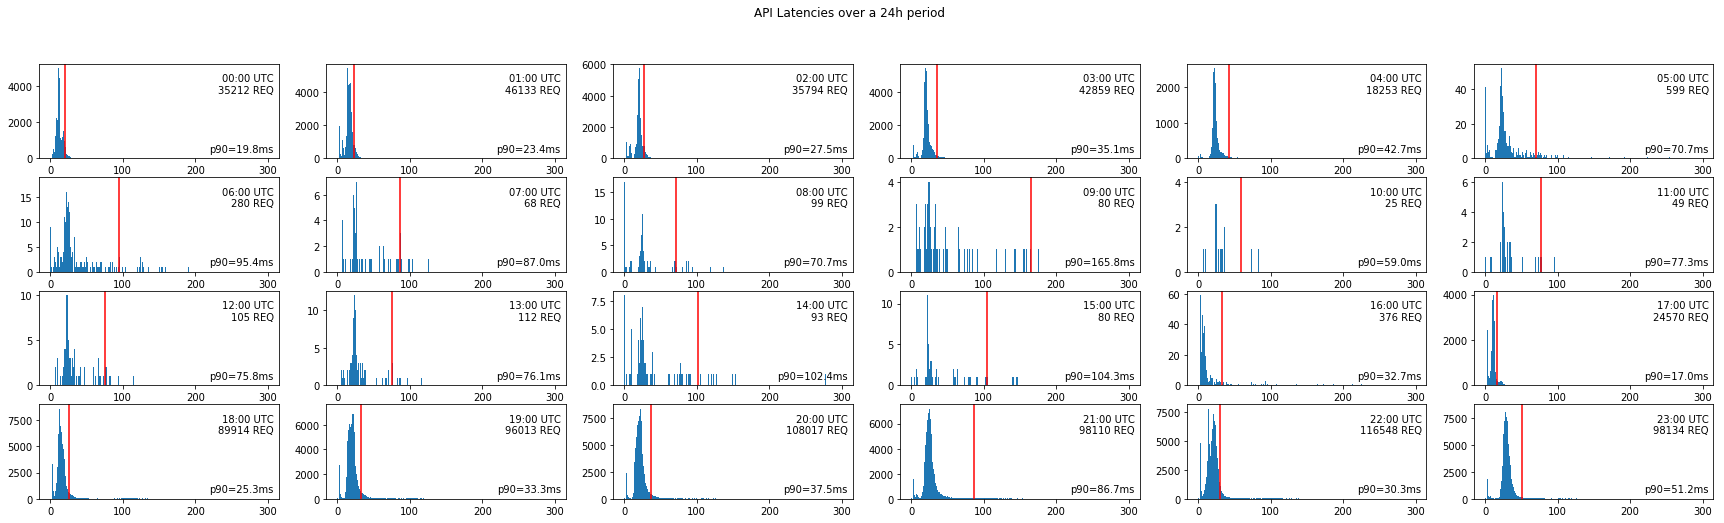

In [17]:
plt.figure(figsize=(30,8))
plt.suptitle("API Latencies over a 24h period")
ax1 =  plt.subplot(6, 4, 1)
# ax1.set_xticks([])
ax1.set_xticks([0,100,200,300])
ax1.tick_params(direction="in")
for i in range(24):
    X = XAL[XAL[:,0] == i, 1] # SELECT latency FROM XAL WHERE h = i
    p = np.percentile(X, 90)
    ax = plt.subplot(4, 6, i+1, sharex=ax1)
    ax.hist(X, bins=np.linspace(0, 300, 300));
    ax.axvline(p, color="red")
    plt.text(0.98, 0.9, '{:02d}:00 UTC\n{} REQ'.format(i, len(X)), horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    plt.text(0.98, 0.05, 'p90={:.1f}ms'.format(p), horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes)

Text(0,0.5,'request count')

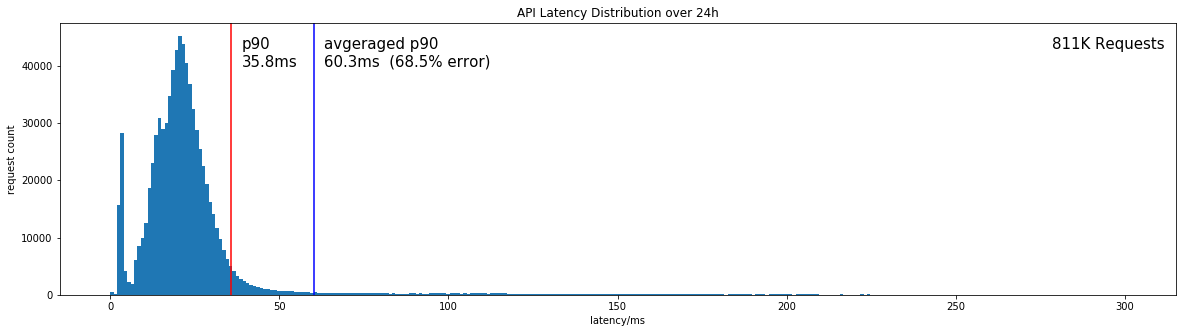

In [18]:
X = XAL[:, 1]
p = np.percentile(X, 90)

p_avg = np.mean([ np.percentile(XAL[XAL[:,0] == i, 1], 90) for i in range(24)])

plt.figure(figsize=(20,5))
ax = plt.subplot(1,1,1)
ax.set_title("API Latency Distribution over 24h")
ax.hist(X, bins=np.linspace(0, 300, 300));
ax.text(0.99, 0.95, '811K Requests'.format(len(X)), horizontalalignment='right', verticalalignment='top', transform=ax.transAxes, fontsize=15)

ax.axvline(p, color="red")
ax.text(p+3, 45000, 'p90\n{:.1f}ms'.format(p), horizontalalignment='left', verticalalignment='top', fontsize=15)

ax.axvline(p_avg, color="blue")
ax.text(p_avg+3, 45000, 'avgeraged p90\n{:.1f}ms  ({:.1f}% error)'.format(p_avg, 100*abs(p_avg-p)/p), horizontalalignment='left', verticalalignment='top', fontsize=15, )
ax.set_xlabel("latency/ms")
ax.set_ylabel("request count")

# Baseline

In [19]:
TABLE = [["method", "p90", "err", "rel-err-%", "latency insert", "latency merge", "latency percentile"]]

In [20]:
p_true = np.percentile(X, 90)
p_true

35.774578652930678

In [21]:
TABLE.append(["-", p_true, 0, 0, 0, 0, 0 ])

## HRD Histograms

In [24]:
!pip install hdrhistogram

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [25]:
from hdrh.histogram import HdrHistogram

In [26]:
M = 10**3 + 0.0

def hdr_new(X):
    h = HdrHistogram(1, 10**256, 3)
    for x in X:
        h.record_value(x * M)
    return h

def hdr_percentile(h, p):
    return h.get_value_at_percentile(p) / M

def hdr_merge(hl):
    h = hdr_new([])
    for g in hl:
        h.add(g)
    return h

In [27]:
%time HDR_LST = [ hdr_new(X) for X in XLST ]

CPU times: user 3.61 s, sys: 0 ns, total: 3.61 s
Wall time: 3.61 s


In [28]:
%time H = hdr_merge(HDR_LST)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.54 ms


In [29]:
%time p_hdr = hdr_percentile(H, 90)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.24 ms


In [30]:
rerr = abs(p_hdr - p_true) / p_true * 100
rerr

0.0011777834573759823

In [31]:
TABLE.append(["HDR Histogram", p_hdr, abs(p_hdr - p_true), abs(p_hdr - p_true)/p_true * 100 , 3.59, 0.00341, 0.00332])

## Circllhist

In [32]:
# Installation
# Source install libcircllhist on Ubuntu
# !git clone https://github.com/circonus-labs/libcircllhist/ && /tmp/libcircllhist && autoconf && ./configure --libdir /usr/lib/x86_64-linux-gnu/ &&  make 
# !cd /tmp/libcircllhist && sudo make install

# Install the python library
# !pip install circllhist

In [33]:
from circllhist import Circllhist

In [34]:
def clh_new(X):
    h = Circllhist()
    for x in X:
        h.insert(x)
    return h

def clh_percentile(h, p):
    return h.quantile(p/100.0)

def clh_merge(hl):
    h = Circllhist()
    for g in hl:
        h.merge(g)
    return h

In [35]:
%time CLHL = [ clh_new(X) for X in XLST ] 

CPU times: user 810 ms, sys: 0 ns, total: 810 ms
Wall time: 816 ms


In [36]:
# %time [ clh_percentile(h, 90) for h in CLHL ]

In [37]:
H = clh_merge(CLHL)
%timeit H = clh_merge(CLHL)

263 µs ± 3.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
p_clh = clh_percentile(H, 90)
%timeit p_clh = clh_percentile(H, 90)

4.79 µs ± 141 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
(p_clh - p_true) / p_true * 100

-0.0036840393831983754

In [40]:
TABLE.append(["Circllhist", p_clh, abs(p_clh - p_true), abs(p_clh - p_true)/p_true * 100, 0.83, 0.000270, 0.000005 ])

## t-digest

In [41]:
# Installation
!pip install tdigest

You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [42]:
from tdigest import TDigest

In [43]:
def td_new(X):
    td = TDigest()
    for x in X: td.update(x, 1)
    td.compress()
    return td

def td_merge(tdl):
    td = TDigest()
    for sd in tdl:
        td = td + sd
    td.compress()
    return td

def td_percentile(td, p):
    return td.percentile(p)

In [44]:
%time TDL = [ td_new(X) for X in XLST ] 

CPU times: user 1min 40s, sys: 10 ms, total: 1min 40s
Wall time: 1min 40s


In [45]:
# %time [ td_percentile(t, 90) for t in TDL ]

In [46]:
T = td_merge(TDL)
%timeit T = td_merge(TDL)

1.82 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
p_td = td_percentile(T, 90)
%timeit p_td = td_percentile(T, 90)

2.92 ms ± 88.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
(p_td - p_true) / p_true * 100

-0.16362447134508418

In [49]:
TABLE.append(["t-digest", p_td, abs(p_td - p_true), abs(p_td - p_true)/p_true * 100, 97, 1.9, 0.00342])

## DD-sketch

In [40]:
# Installation
!cd /tmp && git clone https://github.com/DataDog/sketches-py.git
!cd /tmp/sketches-py && python setup.py install
import sys
sys.path.append("/opt/conda/lib/python3.6/site-packages/sketches-0.1-py3.6.egg")

Cloning into 'sketches-py'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 166 (delta 17), reused 32 (delta 11), pack-reused 118
Receiving objects: 100% (166/166), 43.01 KiB | 0 bytes/s, done.
Resolving deltas: 100% (66/66), done.
Checking connectivity... done.
running install
running bdist_egg
running egg_info
creating sketches.egg-info
writing sketches.egg-info/PKG-INFO
writing dependency_links to sketches.egg-info/dependency_links.txt
writing requirements to sketches.egg-info/requires.txt
writing top-level names to sketches.egg-info/top_level.txt
writing manifest file 'sketches.egg-info/SOURCES.txt'
reading manifest file 'sketches.egg-info/SOURCES.txt'
writing manifest file 'sketches.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/ddsketch
copying ddsketch/ddsketc

In [50]:
from ddsketch.ddsketch import DDSketch

In [51]:
def dd_new(X):
    dd = DDSketch()
    for x in X: dd.add(x)
    return dd

def dd_merge(ddl):
    dd = DDSketch()
    for ed in ddl:
        dd.merge(ed)
    return dd

def dd_percentile(dd, p):
    return dd.quantile(p / 100.0)

In [52]:
%time DDL = [ dd_new(X) for X in XLST ] 

CPU times: user 2.53 s, sys: 0 ns, total: 2.53 s
Wall time: 2.53 s


In [53]:
# %time [ dd_percentile(dd, 90) for dd in DDL ]

In [54]:
DD = dd_merge(DDL)
%timeit DD = dd_merge(DDL)

3.55 ms ± 87.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
p_dd = dd_percentile(DD, 90)
%timeit p_dd = dd_percentile(DD, 90)

37.6 µs ± 399 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [56]:
(p_dd - p_true) / p_true * 100

-0.71429103186549214

In [57]:
TABLE.append(["dd-sketch", p_dd, abs(p_dd - p_true), abs(p_dd - p_true)/p_true * 100, 2.56, 0.00368, 0.000037])

# Results

In [58]:
from tabulate import tabulate

In [59]:
print(tabulate(TABLE, floatfmt="0.2f"))

-------------  -----------------  ----------------------  ---------------------  --------------  -------------  ------------------
method         p90                err                     rel-err-%              latency insert  latency merge  latency percentile
-              35.77457865293068  0                       0                      0               0              0
HDR Histogram  35.775             0.00042134706932017707  0.0011777834573759823  3.59            0.00341        0.00332
Circllhist     35.77326070336393  0.0013179495667472452   0.0036840393831983754  0.83            0.00027        5e-06
t-digest       35.71604268773389  0.058535965196789164    0.16362447134508418    97              1.9            0.00342
dd-sketch      35.51904404592513  0.25553460700555064     0.7142910318654921     2.56            0.00368        3.7e-05
-------------  -----------------  ----------------------  ---------------------  --------------  -------------  ------------------
